<a href="https://colab.research.google.com/github/tanyakuznetsova/Amazon-Handmade-Reviews-23-Sentiment-and-NER/blob/main/Amazon_Handmade_Reviews_Sentiment_Labeling_and_NER_w_AWS_Comprehend_and_SpaCy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis and Labeling

Data used: https://amazon-reviews-2023.github.io/


In this notebook I use a subset of the Amazon Reviews 2023 dataset, collected by my UCSD professor Julian McAuley and his team, focusing on  664162 reviews of Amazon Handmade items. I compare the performance of two NLP systems:

- **SpaCy with eng_spacysentiment**: a sentiment analysis tool built on SpaCy.
- **AWS Comprehend API**: Amazon's propriatary cloud-based NLP system for sentiment analysis with high accuracy and Named Entity Recognition (NER).

In [1]:
#necessary libraries

import json
import gzip
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
!pip install boto3 -q
!pip install spacy==3.7.2 -q
!pip install eng_spacysentiment -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 919.6/919.6 kB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.7.1 requires spacy<3.8.0,>=3.7.2, but you hav

In [3]:
import spacy
import eng_spacysentiment
import boto3
from botocore.exceptions import NoCredentialsError
from google.colab import userdata
AWS_ACCESS_KEY_ID = userdata.get('AWS_ACCESS_KEY_ID') #userdata.get equiv to os.getenv()
AWS_SECRET_ACCESS_KEY = userdata.get('AWS_SECRET_ACCESS_KEY')


region_name = 'us-west-2'

client = boto3.client('comprehend',
                      aws_access_key_id=AWS_ACCESS_KEY_ID,
                      aws_secret_access_key=AWS_SECRET_ACCESS_KEY,
                      region_name=region_name)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
datapath = '/content/drive/My Drive/Handmade_Products.jsonl.gz'

with gzip.open(datapath, 'r') as f:
  data = [json.loads(line) for line in f]

df = pd.DataFrame(data)

In [6]:
df.head(3)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Beautiful colors,I bought one for myself and one for my grandda...,[],B08GPJ1MSN,B08GPJ1MSN,AF7OANMNHQJC3PD4HRPX2FATECPA,1621607495111,1,True
1,5.0,You simply must order order more than one!,I’ve ordered three bows so far. Have not been ...,[],B084TWHS7W,B084TWHS7W,AGMJ3EMDVL6OWBJF7CA5RGJLXN5A,1587762946965,0,True
2,5.0,Great,As pictured. Used a frame from the dollar stor...,[],B07V3NRQC4,B07V3NRQC4,AEYORY2AVPMCPDV57CE337YU5LXA,1591448951297,0,True


In [7]:
len(df)

664162

The following function, ```analyze_sentiment_AWS``` makes an API call using AWS Comprehend and returns the overall sentiment and the associated scores for positive, negative, neutral and mixed sentiment expressed in a text.

In [8]:
def analyze_sentiment_AWS(text):
    response = client.detect_sentiment(
        Text = text,
        LanguageCode = 'en')

    return response['Sentiment'], response['SentimentScore']

In [9]:
df.loc[3, 'text']

'This is beyond beautiful.  So shiny, the size is just right to make this an everyday necklace. Dainty but not tiny or cheap. Mine doesnt bend like other reviews said its strong and the back is nice and smooth. The chain is very strong. I highly recommend this necklace, its gorgeous, I love it so much'

In [10]:
analyze_sentiment_AWS(df.loc[3, 'text'])

('POSITIVE',
 {'Positive': 0.9998457431793213,
  'Negative': 2.913576281571295e-05,
  'Neutral': 7.505299436161295e-05,
  'Mixed': 5.0066686526406556e-05})

Also a look at a negative review and its analysis with AWS Comprehend:

In [11]:
df_neg = df[df['rating'] <=2]
df_neg.head(3)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
32,1.0,Came with the wrong name,I ordered three for each one of my granddaught...,[],B018OJP0OO,B018OJP0OO,AGYBOBPV47L6FRILNSZ7S6XFLPFA,1652374009536,0,True
33,1.0,Weird,Small size ...for a kid and awkward to put on,[],B08B5QPRPP,B08B5QPRPP,AEMJ2EG5ODOCYUTI54NBXZHDJGSQ,1603255150515,0,True
34,1.0,Like really stupid,Are we all LIKE illiterate kids?,[],B06VWPF16J,B06VWPF16J,AEMJ2EG5ODOCYUTI54NBXZHDJGSQ,1522403460061,0,False


In [12]:
df_neg.loc[32, 'text']

'I ordered three for each one of my granddaughters.<br />Two of them said the same name and the other one was OK had to send it all back the order was wrong very disappointed'

In [13]:
analyze_sentiment_AWS(df_neg.loc[33, 'text'])

('NEGATIVE',
 {'Positive': 0.0053137075155973434,
  'Negative': 0.9676792025566101,
  'Neutral': 0.026253264397382736,
  'Mixed': 0.0007539002690464258})

### Creating a subset

 For the purposes of my analysis, I will be using a subset of 1000 rows selected at random from the large-scale reviews data containing more than 660000 reviews:

In [14]:
reviews = df[['rating', 'title', 'text', 'asin']]
df_small = reviews.sample(n = 1000,
                         random_state = 100) #for reproducibility

#data cleaning: ensuring all rows have actual text in the review, dropping any rows with no review text

df_small = df_small[df_small['text'].notna() & (df_small['text'] != '')]
df_small.reset_index(inplace = True)
print(len(df_small))

1000


Eng_spacysentiment is a package built on top of SpaCy and is a straightforward way to go about sentiment analysis and labeling text.

In [15]:
nlp = eng_spacysentiment.load()

def spacy_sentiment(text):
    analysis = nlp(text)
    pos_score = analysis.cats.get('positive', 0.0)
    neg_score = analysis.cats.get('negative', 0.0)
    neut_score = analysis.cats.get('neutral',  0.0)

    if pos_score > max(neg_score, neut_score):
        return 'positive'
    elif neg_score > max(pos_score, neut_score):
        return 'negative'
    else: return 'neutral' #eng_sentiment does not have 'mixed' category

In [16]:
nlp('it was nothing special').cats #spacy thinks a neutral statement is positive

{'positive': 0.8192574977874756,
 'negative': 0.07259658724069595,
 'neutral': 0.10814588516950607}

In [17]:
spacy_sentiment('it was nothing special')

'positive'

In [18]:
df_small['spacy_sentiment'] = df_small['text'].apply(spacy_sentiment)

In [19]:
#takes over a minute to run
df_small['aws_sentiment'], df_small['aws_sentiment_score'] = zip(*df_small['text'].apply(analyze_sentiment_AWS))

In [20]:
df_small.head(3)

,index,rating,title,text,asin,spacy_sentiment,aws_sentiment,aws_sentiment_score
0,460684,5.0,Great product,These outlet/switch covers put the perfect fin...,B09SB3TP8V,positive,POSITIVE,"{'Positive': 0.9996793270111084, 'Negative': 2..."
1,455573,5.0,Fantastic!,This is a beautiful wallet. I do use it as a w...,B07Z5G2M2H,positive,POSITIVE,"{'Positive': 0.9996931552886963, 'Negative': 2..."
2,412365,5.0,10/10,So cute & a great christmas present!!,B091DBVC8H,positive,POSITIVE,"{'Positive': 0.9995455145835876, 'Negative': 4..."


In [21]:
df_small['aws_sentiment'] = df_small['aws_sentiment'].str.lower() #originally in capital letters

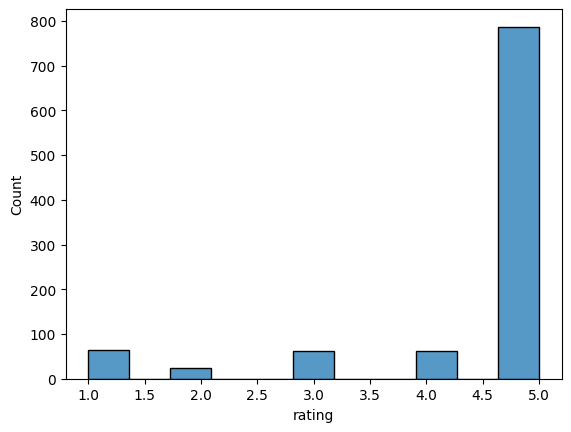

In [22]:
sns.histplot(x = df_small['rating'])
plt.show()

The reviews are overwhelmingly positive! Yay for happy customers.
Let's visualize sentiment breakdown returned by both SpaCy and AWS Comprehend:

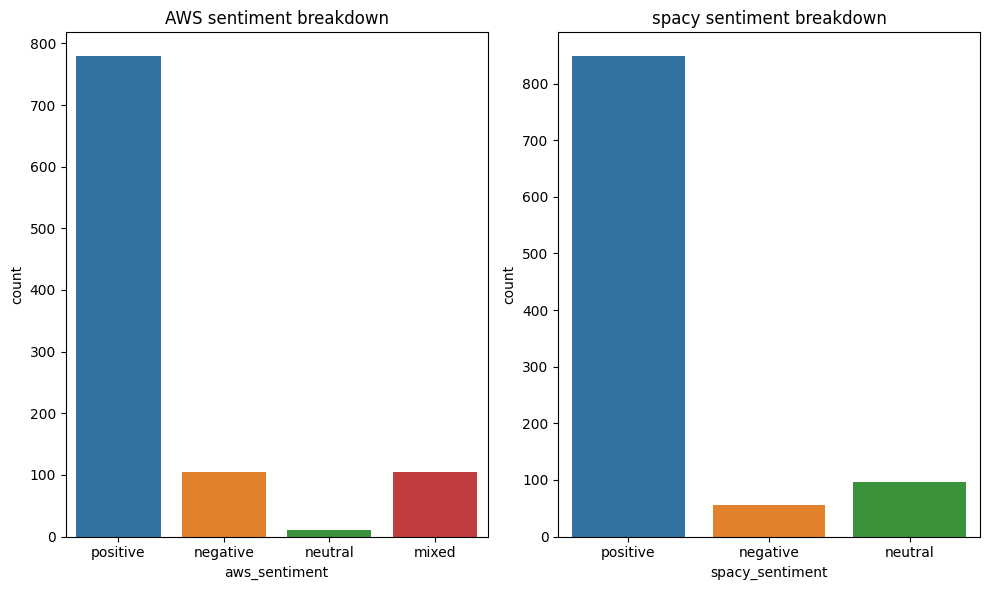

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))

sns.countplot(x = df_small['aws_sentiment'],
              hue = df_small['aws_sentiment'],
              #palette = 'coolwarm',
              ax = ax1,
              legend = False
              )
ax1.set_title('AWS sentiment breakdown')

sns.countplot(x = df_small['spacy_sentiment'],
              hue = df_small['spacy_sentiment'],
              ax = ax2,
              legend = False)
ax2.set_title('spacy sentiment breakdown')
plt.tight_layout()
plt.show()

In [24]:
df_small['AWS_SpaCy_match'] = df_small.apply(lambda row: row['aws_sentiment'] == row['spacy_sentiment'], axis=1)

In [25]:
df_small.head(3)

,index,rating,title,text,asin,spacy_sentiment,aws_sentiment,aws_sentiment_score,AWS_SpaCy_match
0,460684,5.0,Great product,These outlet/switch covers put the perfect fin...,B09SB3TP8V,positive,positive,"{'Positive': 0.9996793270111084, 'Negative': 2...",True
1,455573,5.0,Fantastic!,This is a beautiful wallet. I do use it as a w...,B07Z5G2M2H,positive,positive,"{'Positive': 0.9996931552886963, 'Negative': 2...",True
2,412365,5.0,10/10,So cute & a great christmas present!!,B091DBVC8H,positive,positive,"{'Positive': 0.9995455145835876, 'Negative': 4...",True


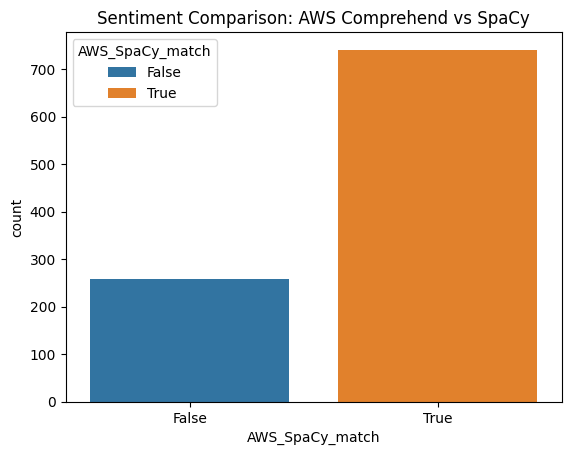

In [26]:
sns.countplot(x = 'AWS_SpaCy_match', data = df_small, hue = 'AWS_SpaCy_match')
plt.title('Sentiment Comparison: AWS Comprehend vs SpaCy')
plt.show()

In [27]:
diff = df_small[df_small['AWS_SpaCy_match'] == False].reset_index()
len(diff)

259

In [28]:
diff.head(3)

,level_0,index,rating,title,text,asin,spacy_sentiment,aws_sentiment,aws_sentiment_score,AWS_SpaCy_match
0,4,374364,2.0,Pretty but small and very strong fragrance!,This wreath was much smaller than I thought it...,B06ZYLWZ3P,positive,negative,"{'Positive': 0.0004798880545422435, 'Negative'...",False
1,5,167052,2.0,Chai pendant,I was disapointed with this pendant.The chain ...,B07DLD8T4F,positive,negative,"{'Positive': 0.00013541827502194792, 'Negative...",False
2,7,163736,5.0,Great product and price,Was a gift,B097YW2R5N,positive,neutral,"{'Positive': 0.18219511210918427, 'Negative': ...",False


In [29]:
diff.loc[1, 'text'] #ground truth: clearly negative

'I was disapointed with this pendant.The chain isnt the way it showed in picture much more fragile.The chai is so thin and tiny you caint see what it is.'

In [30]:
nlp(diff.loc[1, 'text']).cats #spacy thinks it's positive! inaccurate

{'positive': 0.7093698978424072,
 'negative': 0.022962767630815506,
 'neutral': 0.26766732335090637}

In [31]:
analyze_sentiment_AWS(diff.loc[1, 'text']) #aws comprehend thinks it's mixed, inaccurate

('NEGATIVE',
 {'Positive': 0.00013541827502194792,
  'Negative': 0.9996685981750488,
  'Neutral': 0.00018312518659513444,
  'Mixed': 1.2949723895872012e-05})

In [32]:
diff.loc[86, 'text'] #ground truth: clearly negative

'Item was chipped, enamel was of poor quality. Should not have shipped, was returned.'

In [33]:
nlp(diff.loc[86, 'text']).cats #spacy thinks it's neutral! inaccurate

{'positive': 0.02066846564412117,
 'negative': 0.36207273602485657,
 'neutral': 0.6172587871551514}

In [34]:
analyze_sentiment_AWS(diff.loc[86, 'text']) #aws correctly identifies as negative

('NEGATIVE',
 {'Positive': 5.2407100156415254e-05,
  'Negative': 0.9998080134391785,
  'Neutral': 5.645064084092155e-05,
  'Mixed': 8.310211705975235e-05})

In [35]:
diff.loc[257, 'text'] #ground truth: mixed at best

'its nice , no big deal ...rings turn color . as you see in the picture they turn to brass color ....the leather part does stretch  to fit size ...again no big deal ..would i buy again,  no i wouldnt'

In [36]:
nlp(diff.loc[257, 'text']).cats #spacy classifies as negative

{'positive': 0.02141527086496353,
 'negative': 0.9785475730895996,
 'neutral': 3.706055576913059e-05}

In [37]:
analyze_sentiment_AWS(diff.loc[257, 'text']) #AWS classifies it as positive, inaccurate

('POSITIVE',
 {'Positive': 0.9471616148948669,
  'Negative': 0.00716090202331543,
  'Neutral': 0.0012041187146678567,
  'Mixed': 0.044473305344581604})

Both sentiment analyzers do a fairly good job. However, on average, spacy makes more mistakes and AWS Comprehend does seem to capture the nuance better, especially with mixed reviews.

# Named Entities Recognition


In [38]:
def analyze_entities_AWS(text):
    response = client.detect_entities(Text=text, LanguageCode='en')

    entities = response['Entities']
    for entity in entities:
      return {"Text": entity['Text'], "Type": entity['Type']}

In [39]:
def spacy_entities(text):
    doc = nlp(text)
    entities = doc.ents
    for entity in entities:
      return {"Text": entity.text, "Type": entity.label_}

In [42]:
!python -m spacy download en_core_web_sm

2024-05-30 13:06:25.482352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 13:06:25.482454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 13:06:25.486036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 13:06:27.016231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.6 MB/s eta 0:00:00
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 3.7.1
    Uninstalling en-core-web-sm-3.7.1:
      Successfully uninstall

In [43]:
nlp = spacy.load('en_core_web_sm')

In [44]:
df_small.loc[393, 'text']

"I ordered the small for my 12lb cat, and it's the perfect size. High quality material, and the engraving is precise and legible. Great quality for the price."

In [45]:
print(analyze_entities_AWS(df_small.loc[393, 'text']))
print(spacy_entities(df_small.loc[393, 'text']))

{'Text': '12lb', 'Type': 'QUANTITY'}
{'Text': '12', 'Type': 'CARDINAL'}


In [46]:
df_small.loc[147, 'text']

'Very pleased with this product! It was a gift for my son who lives in Texas and he really loves it.'

In [47]:
print(analyze_entities_AWS(df_small.loc[147, 'text']))
print(spacy_entities(df_small.loc[147, 'text']))

{'Text': 'Texas', 'Type': 'LOCATION'}
{'Text': 'Texas', 'Type': 'GPE'}


In [48]:
df_small['spacy_entities'] = df_small['text'].apply(spacy_entities)
df_small['aws_entities'] = df_small['text'].apply(analyze_entities_AWS)

In [49]:
with_entities = df_small[(df_small['spacy_entities'].notna() | df_small['aws_entities'].notna())]

In [50]:
with_entities.head(10)

,index,rating,title,text,asin,spacy_sentiment,aws_sentiment,aws_sentiment_score,AWS_SpaCy_match,spacy_entities,aws_entities
2,412365,5.0,10/10,So cute & a great christmas present!!,B091DBVC8H,positive,positive,"{'Positive': 0.9995455145835876, 'Negative': 4...",True,"{'Text': 'christmas', 'Type': 'DATE'}","{'Text': 'christmas', 'Type': 'EVENT'}"
4,374364,2.0,Pretty but small and very strong fragrance!,This wreath was much smaller than I thought it...,B06ZYLWZ3P,positive,negative,"{'Positive': 0.0004798880545422435, 'Negative'...",False,"{'Text': 'over $9', 'Type': 'MONEY'}","{'Text': 'over $9', 'Type': 'QUANTITY'}"
11,509439,5.0,My daughter and her husband love it.,Had this delivered sight unseen to my daughter...,B01MT22WPM,positive,positive,"{'Positive': 0.997093677520752, 'Negative': 5....",True,"{'Text': 'first', 'Type': 'ORDINAL'}","{'Text': 'first', 'Type': 'QUANTITY'}"
14,590115,5.0,Five Stars,Got these for my wife with the blue she loves ...,B0173VYAQS,positive,positive,"{'Positive': 0.999671459197998, 'Negative': 5....",True,None,"{'Text': 'both of them', 'Type': 'QUANTITY'}"
17,636105,5.0,beautiful and Lasts YEARS,I first ordered this keychain in April of 2019...,B0779MS18Z,positive,positive,"{'Positive': 0.9997155070304871, 'Negative': 7...",True,"{'Text': 'first', 'Type': 'ORDINAL'}","{'Text': 'first', 'Type': 'QUANTITY'}"
18,279687,5.0,Love it,Love it,B07DVSZ529,positive,positive,"{'Positive': 0.9998137354850769, 'Negative': 3...",True,"{'Text': 'Love', 'Type': 'WORK_OF_ART'}",None
19,379755,5.0,NO MORE BEARD BEND!,Hate using masks because they all crease my be...,B09QFNLH82,positive,positive,"{'Positive': 0.9617697596549988, 'Negative': 0...",True,"{'Text': 'more than one', 'Type': 'CARDINAL'}","{'Text': 'one', 'Type': 'QUANTITY'}"
21,267412,2.0,Actual size and photo is not accurate,Very misleading in size. The photo provided is...,B06VWH9VRK,positive,negative,"{'Positive': 5.199307270231657e-05, 'Negative'...",False,"{'Text': '16', 'Type': 'MONEY'}","{'Text': '$16', 'Type': 'QUANTITY'}"
27,182746,5.0,IT'S BEAUTIFUL!,The ornament is larger than I expected and is ...,B017E212ZS,positive,positive,"{'Positive': 0.9995531439781189, 'Negative': 0...",True,None,"{'Text': 'Christmas', 'Type': 'EVENT'}"
28,645849,1.0,Garbage!,Save your money! These eatings definitely not ...,B09GC7DVH2,positive,negative,"{'Positive': 0.0007912496221251786, 'Negative'...",False,"{'Text': 'first', 'Type': 'ORDINAL'}","{'Text': '2 month', 'Type': 'QUANTITY'}"


I chose to create dictionaries with entities returned by AWS and SpaCy so that they are easily available for further analysis and easy extraction.

In [51]:
len(with_entities) #how many rows out of 1000 have any entities?

380

 On average, the majority (62%) of the reviews don't actually contain any entities, but those that do present valuable information that can be analyzed.

In [52]:
spacy_entities_expanded = pd.json_normalize(with_entities['spacy_entities'])
spacy_entities_expanded = spacy_entities_expanded.dropna()

In [53]:
spacy_entities_expanded.Text.str

In [54]:
aws_entities_expanded = pd.json_normalize(with_entities['aws_entities'])
aws_entities_expanded = aws_entities_expanded.dropna()
aws_entities_expanded.Text.str

In [55]:
aws_entities_expanded.describe()

,Text,Type
count,305,305
unique,232,9
top,one,QUANTITY
freq,20,189


In [56]:
spacy_entities_expanded.describe()

,Text,Type
count,330,330
unique,190,14
top,Love,CARDINAL
freq,23,77


Creating a word cloud is one of my favorite ways to visualize insights derived from natural language data. Comparing entities derived with AWS Comprehend and Spacy:

In [57]:
from wordcloud import WordCloud #, STOPWORDS, ImageColorGenerator

aws_ents = " ".join(word for word in aws_entities_expanded['Text'])
spacy_ents = " ".join(word for word in spacy_entities_expanded['Text'])

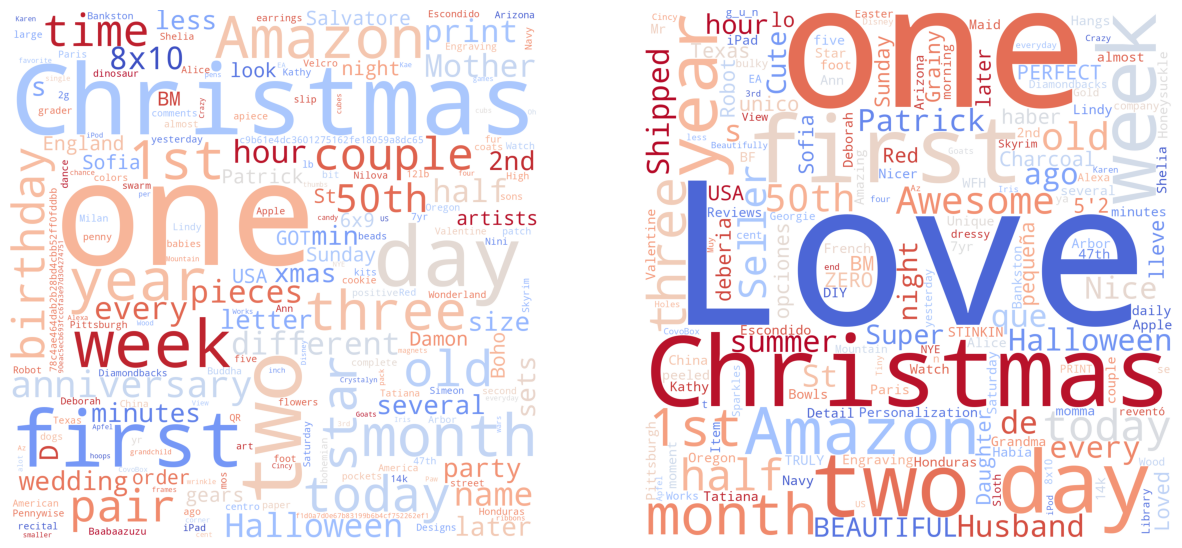

In [58]:
wordcloud_aws = WordCloud(background_color = 'white',
                            colormap = 'coolwarm',
                            width = 1600,
                            height = 1600,
                            min_font_size = 10).generate(aws_ents)

wordcloud_spacy = WordCloud(background_color = 'white',
                          colormap = 'coolwarm',
                          width = 1600,
                          height = 1600,
                          min_font_size = 10).generate(spacy_ents)

plt.figure(figsize = (15, 15))
plt.subplot(1,2, 1)
plt.imshow(wordcloud_aws)
plt.axis('off')

plt.subplot(1,2, 2)
plt.imshow(wordcloud_spacy)
plt.axis('off')
plt.show()

# AWS Comprehend vs SpaCy: Conclusion

In this project, I compared the performance of AWS Comprehend and SpaCy (including the eng_spacysentiment extension) for sentiment analysis and Named Entity Recognition on a subset of Amazon Handmade reviews.I found that:

**Sentiment Analysis:**

AWS Comprehend generally outperforms SpaCy in sentiment analysis. It captures nuances better and provides an additional 'mixed' category, enhancing its ability to reflect sentiment complexity.
SpaCy often over- or undershoots sentiment classification and struggles with short, clearly positive reviews (e.g., "Cute!" or "Beautiful"), sometimes mislabeling them as neutral. In contrast, AWS Comprehend consistently labels such reviews correctly as positive. Generally, it provides robust sentiment analysis and broad category distinctions.

**Named Entity Recognition (NER):**

AWS Comprehend tends to categorize all numerical expressions as 'QUANTITY,' which lacks precision.
SpaCy offers a more nuanced categorization, distinguishing between 'CARDINAL', 'ORDINAL' numbers as well as 'MONEY', providing more detailed entity recognition.

A further thorough evaluation would involve manually labeling the ground truth for misclassified reviews, which presents scope for possible future work.

 Overall, AWS Comprehend shows impressive performance in sentiment analysis, whereas SpaCy excels in providing detailed NER results.

